In [1]:
import sys
sys.path.append("..")
# from sklearn.datasets import load_wine
from deep_svdd import BaseSVDD
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import cv2
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models

In [2]:
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im

X_train = X_train/255
X_test_good = X_test_good/255
X_test_error = X_test_error/255
x_train, x_test = train_test_split(X_train, test_size=0.2)
X_test = np.concatenate([X_test_good, X_test_error])

In [1]:
image_height, image_width = 256,256
input_shape = (256,256, 3)

model = models.Sequential()

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
model.compile(optimizer='adam',loss='binary_crossentropy')
model.summary()

model.fit(x_train, x_train,epochs=5,batch_size=64,shuffle=True,validation_data=(x_test, x_test))
score = model.evaluate(x_test, x_test, verbose=0)
print('test xentropy:', score)

NameError: name 'models' is not defined

In [5]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',
                loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(7):
    encoder.pop()

X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
X_ts = encoder.predict(X_test,verbose=0)
x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

In [6]:
# x_tr = X_train
# x_tg = X_test_good
# x_te = X_test_good

y_tr = np.ones(len(X_tr))
y_tg = np.ones(len(X_tg))
y_te = []
for i in range(len(x_te)):
    y_te.append(-1)
y_te = np.array(y_te)
y_ts = np.concatenate([y_tg, y_te])

y_tr = np.reshape(y_tr,(X_tr.shape[0], 1))
y_tg = np.reshape(y_tg,(X_tg.shape[0], 1))
y_te = np.reshape(y_te,(X_te.shape[0], 1))
y_ts = np.reshape(y_ts,(X_ts.shape[0], 1))

C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:269: RuntimeWarning: invalid value encountered in sqrt
  self.radius = np.sqrt(np.mean(np.diag(K)) + self.offset+np.mean(tmp_[self.boundary_indices, 0]))




*** Fitting of the SVDD model is completed. ***

running time         = 0.1811 seconds
kernel function      = poly
iterations           = 10
number of samples    = 209
number of features   = 8192
number of features   = nan %
number of SVs        = 7
ratio of SVs         = 3.3493 %
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0162 seconds
number of samples    = 83
number of alarm      = 0
accuracy             = 24.0964 %




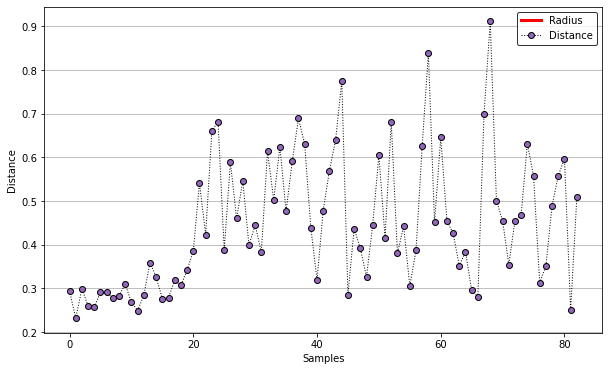

CPU times: total: 1.11 s
Wall time: 494 ms


In [54]:
%%time
# svdd = BaseSVDD(C=2**(-7), kernel='linear', display='on')
svdd = BaseSVDD(C=2**(-1), degree=3, kernel='poly', display='on')
# svdd = BaseSVDD(C=2**(-1), gamma='scale', kernel='rbf', display='on')
# svdd = BaseSVDD(C=2**(-5), gamma=0.01, kernel='sigmoid', display='on')

svdd.fit(x_tr, y_tr)
# pre_t = svdd.predict(x_tr, y_tr)
# pre_g = svdd.predict(x_tg, y_tg)
# pre_e = svdd.predict(x_te, y_te)
pre_s = svdd.predict(x_ts, y_ts)
radius = svdd.radius
# distance = svdd.get_distance(x_tg)
# svdd.plot_distance(radius, distance)
# distance = svdd.get_distance(x_te)
# svdd.plot_distance(radius, distance)

distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C

In [156]:
m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :, :, :]))
#   elif alphas[i] == Param:
#     SV.append(list(X_train[i, :, :, :]))
  else:
    NSV.append(list(X_train[i, :, :, :]))

sv = np.array(SV)
nsv = np.array(NSV)

In [158]:
model.fit(sv, sv,epochs=50,batch_size=32,shuffle=True,validation_data=(X_train, X_train))
score = model.evaluate(x_test, x_test, verbose=0)
print('test xentropy:', score)

Epoch 1/50
1/1 [==============================] - 11s 11s/step - loss: 0.6042 - val_loss: 0.5875
Epoch 2/50
1/1 [==============================] - 11s 11s/step - loss: 0.5864 - val_loss: 0.5729
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: 0.5719 - val_loss: 0.5614
Epoch 4/50
1/1 [==============================] - 11s 11s/step - loss: 0.5604 - val_loss: 0.5525
Epoch 5/50
1/1 [==============================] - 11s 11s/step - loss: 0.5515 - val_loss: 0.5458
Epoch 6/50
1/1 [==============================] - 11s 11s/step - loss: 0.5446 - val_loss: 0.5391
Epoch 7/50
1/1 [==============================] - 11s 11s/step - loss: 0.5379 - val_loss: 0.5318
Epoch 8/50
1/1 [==============================] - 10s 10s/step - loss: 0.5307 - val_loss: 0.5246
Epoch 9/50
1/1 [==============================] - 11s 11s/step - loss: 0.5235 - val_loss: 0.5179
Epoch 10/50
1/1 [==============================] - 11s 11s/step - loss: 0.5168 - val_loss: 0.5115
Epoch 11/50
1/1 [============

In [160]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',
                loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(7):
    encoder.pop()

X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
X_ts = encoder.predict(X_test,verbose=0)
x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))



*** Fitting of the SVDD model is completed. ***

running time         = 0.1736 seconds
kernel function      = linear
iterations           = 18
number of samples    = 209
number of features   = 8192
number of features   = 1.1434 %
number of SVs        = 9
ratio of SVs         = 4.3062 %
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0160 seconds
number of samples    = 83
number of alarm      = 83
accuracy             = 75.9036 %




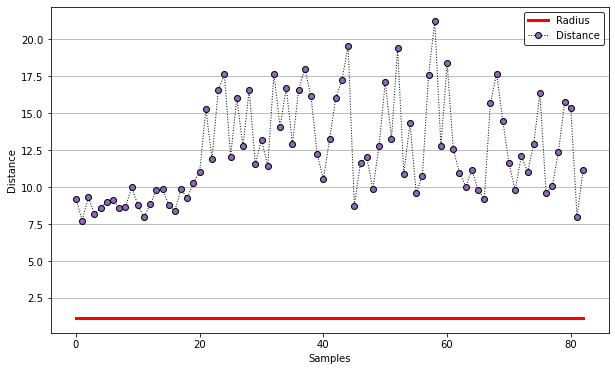

CPU times: total: 1.05 s
Wall time: 495 ms


In [165]:
%%time
svdd = BaseSVDD(C=0.3, kernel='linear', display='on')
# svdd = BaseSVDD(C=2**(-4), degree=5, kernel='poly', display='on')
# svdd = BaseSVDD(C=2**(-5), gamma=0.01, kernel='rbf', display='on')
# svdd = BaseSVDD(C=2**(-5), gamma=0.01, kernel='sigmoid', display='on')

svdd.fit(x_tr, y_tr)
# pre_t = svdd.predict(x_tr, y_tr)
# pre_g = svdd.predict(x_tg, y_tg)
# pre_e = svdd.predict(x_te, y_te)
pre_s = svdd.predict(x_ts, y_ts)
radius = svdd.radius
# distance = svdd.get_distance(x_tg)
# svdd.plot_distance(radius, distance)
# distance = svdd.get_distance(x_te)
# svdd.plot_distance(radius, distance)

distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C